<a href="https://colab.research.google.com/github/akashbagwan2308/8051-basic-programs/blob/main/BatchD_Group01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection

In [1]:
!pip install --upgrade imutils

## Importing Dependencies

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [26]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Downloading Datasets

In [5]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d ahemateja19bec1025/facemask-dataset

 81% 41.0M/50.4M [00:00<00:00, 90.7MB/s]
100% 50.4M/50.4M [00:00<00:00, 87.0MB/s]


In [7]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/facemask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [27]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/facemask-dataset/dataset"))
data = []
labels = []

[INFO] loading images...


In [28]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

## Creating Model

In [29]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Partition the data into training and testing splits
(train_data, test_data, train_labels, test_labels) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model using ExponentialDecay for learning rate
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.96)
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(train_data, train_labels, batch_size=32),
    steps_per_epoch=len(train_data) // 32,
    validation_data=(test_data, test_labels),
    validation_steps=len(test_data) // 32,
    epochs=10)

# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=32)

# For each image in the testing set, find the index of the label with the corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] training head...
Epoch 1/10
34/34 [==============================] - 61s 2s/step - loss: 0.1517 - accuracy: 0.9522 - val_loss: 0.0185 - val_accuracy: 0.9891
Epoch 2/10
34/34 [==============================] - 60s 2s/step - loss: 0.0181 - accuracy: 0.9934 - val_loss: 0.0361 - val_accuracy: 0.9855
Epoch 3/10
34/34 [==============================] - 58s 2s/step - loss: 0.0172 - accuracy: 0.9953 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 4/10
34/34 [==============================] - 59s 2s/step - loss: 0.0223 - accuracy: 0.9934 - val_loss: 0.0122 - val_accuracy: 0.9928
Epoch 5/10
34/34 [==============================] - 61s 2s/step - loss: 0.0126 - accuracy: 0.9953 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 6/10
34/34 [==============================] - 61s 2s/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9964
Epoch 7/10
34/34 [==============================] - 59s 2s/step - loss: 0.0130 - accuracy: 0.9953 - val_loss: 0.0077 - val_accuracy: 0.9

## Saving Model


[INFO] saving mask detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


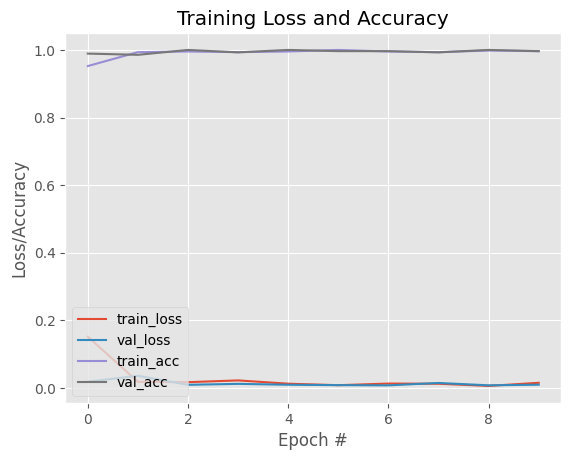

In [31]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("./FaceMaskDetectionModel", save_format="h5")

# Specify the correct number of epochs used during training
N = 10  # Assuming you trained for 10 epochs, replace it with the actual number of epochs

# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Prediction Making

1/1 [==============================] - 0s 499ms/step


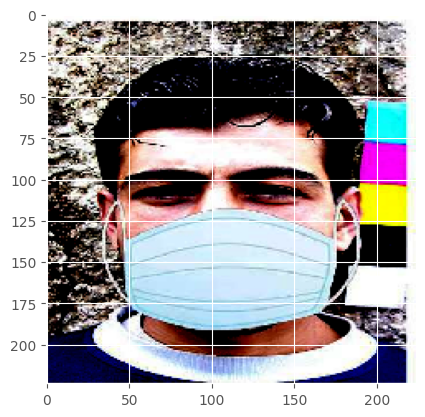

Predicted: 
1
True:
1


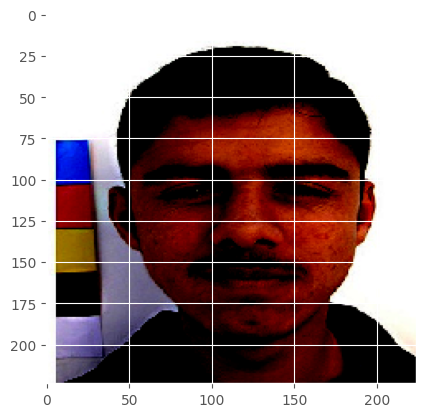

Predicted: 
0
True:
0


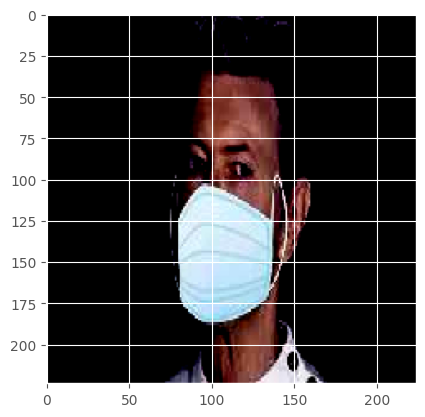

Predicted: 
1
True:
1


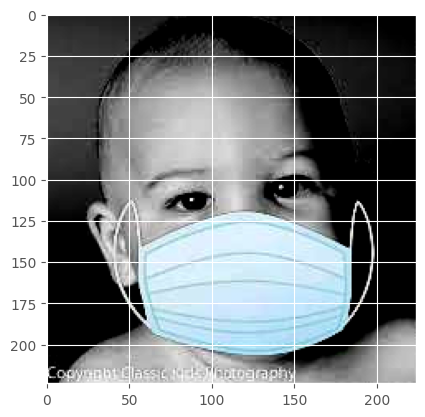

Predicted: 
1
True:
1


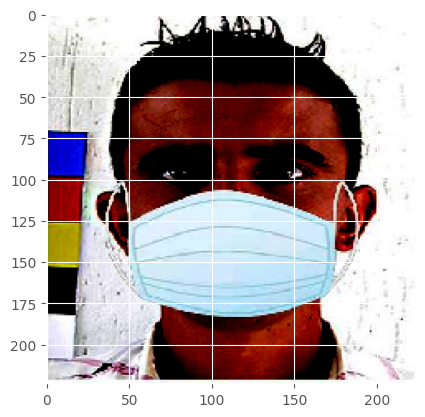

Predicted: 
1
True:
1


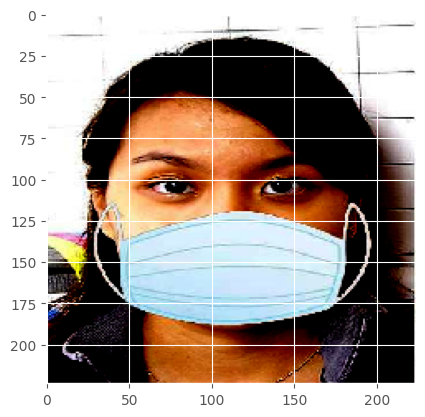

Predicted: 
1
True:
1


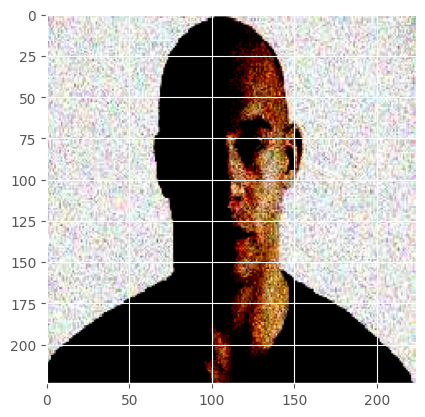

Predicted: 
0
True:
0


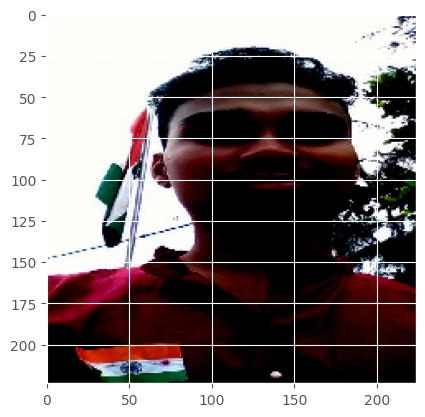

Predicted: 
0
True:
0


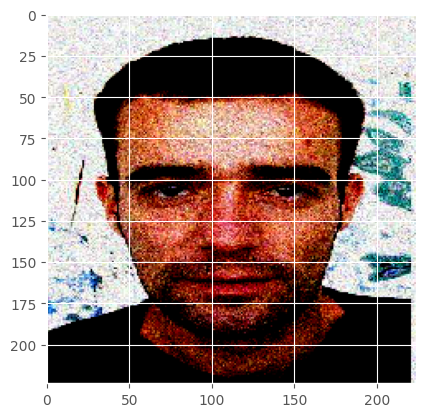

Predicted: 
0
True:
0


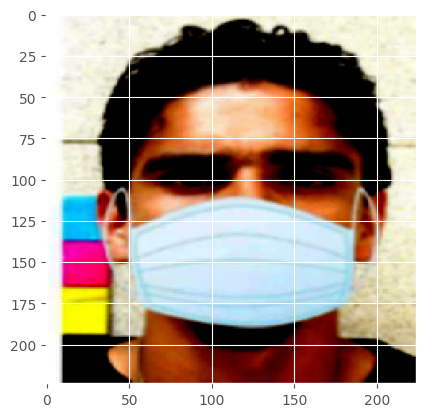

Predicted: 
1
True:
1


In [32]:
Predictions=model.predict(testX[10:20])
for i in range(10,20):
    X_1=testX[i]
    Y_1=testY[i]
    plt.imshow(X_1)
    plt.show()
    print("Predicted: ")
    print(np.argmax(Predictions[i-10]))
    print("True:")
    print(np.argmax(testY[i]))


In [43]:
!wget -q -O - ipv4.icanhazip.com

34.73.96.115


In [44]:
!streamlit run app.py & npx localtunnel --port 8501

[######............] \ diffTrees: sill install generateActionsToTake


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.96.115:8501

npx: installed 22 in 6.646s
your url is: https://violet-squids-love.loca.lt
2024-02-26 14:48:25.895019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 14:48:25.895098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 14:48:25.898858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 14:48:27.410373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:3

/bin/bash: line 1: streamlit: command not found
npx: installed 22 in 1.671s
your url is: https://great-lines-stick.loca.lt
^C
